# Big Data Project

by: Ikhwanul Muslimin

data: [kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store)


# Business Question:
* Most purchased brand in October
* Most popular category in October
* How many visitors each date in October
* Most popular day in October
* How good is our sales over time?
* How to increase the probability for user to buy the item?

# Import the library

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from xgboost import XGBClassifier

# Read the data

Due to limited resources, on this notebook I will only take October data only.

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv
/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv


In [3]:
oct_data = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')

# Data Preprocessing

First, let's see what our data looks like. WOW! We have so much data! The data consist of around 42 million rows and 9 columns (features). 

## Let's look into our data

In [4]:
oct_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## Type of each feature

As we can see, the <code>event_time</code> is still in <code>object</code>, so we have to change it into <code>datetime</code> type. And, both <code>category_code</code> and <code>event_type</code> are still in object, I think it's better to change them into <code>category</code> type. Other features looks fine.

In [5]:
oct_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


Then, we have to check if <code>event_type</code> is only consist of view, purchase, and cart.

In [6]:
print(pd.unique(oct_data['event_type']))

['view' 'purchase' 'cart']


Looks good, so we can change the type.

In [7]:
# change into datetime
oct_data['event_time'] = pd.to_datetime(oct_data['event_time']).dt.tz_convert(None)
# change into category
oct_data['event_type'] = oct_data['event_type'].astype('category')
oct_data['category_code'] = oct_data['category_code'].astype('category')

## Check for <code>null</code> values

As we can see, there are many <code>null</code> values in <code>category_code</code> and <code>brand</code> both in October's data. But, we can't ignore that because it is important for some insights. And, we can't fill that either with some value. So we will leave it <code>null</code> for now. Then, we should drop the missing value in <code>user_session</code>.

In [8]:
oct_data.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [9]:
oct_data = oct_data[oct_data['user_session'].notna()]

## Check for outliers

The minimum data of our <code>price</code> is 0, I think it's fine, because in e-commerce industry commonly there's an event called Flash Sale. About the outliers, we can't remove them all, because our item is varies in multiple category, so for now, just let it be.

In [10]:
oct_data['price'].describe()

count    4.244876e+07
mean     2.903237e+02
std      3.582692e+02
min      0.000000e+00
25%      6.598000e+01
50%      1.629300e+02
75%      3.585700e+02
max      2.574070e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

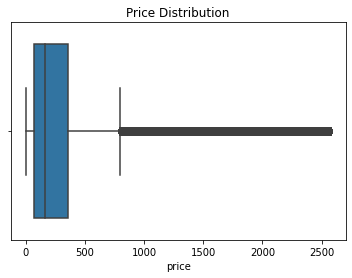

In [11]:
sns.boxplot(x=oct_data['price']).set_title('Price Distribution')

# Exploratory Data Analysis

## Most popular brand in October

We can see that in the top 10 most popular brand in October are dominated by smartphone brand.

In [40]:
brand_data = oct_data.groupby(by=['brand']).agg(N_views=('brand','count'),
                                                N_users=('user_id',lambda x: x.nunique()),
                                                N_sessions=('user_session',pd.Series.nunique)).reset_index()
brand_data_sorted = brand_data.sort_values(by='N_views',ascending=False)

Text(0.5, 0.98, 'Brand Analysis')

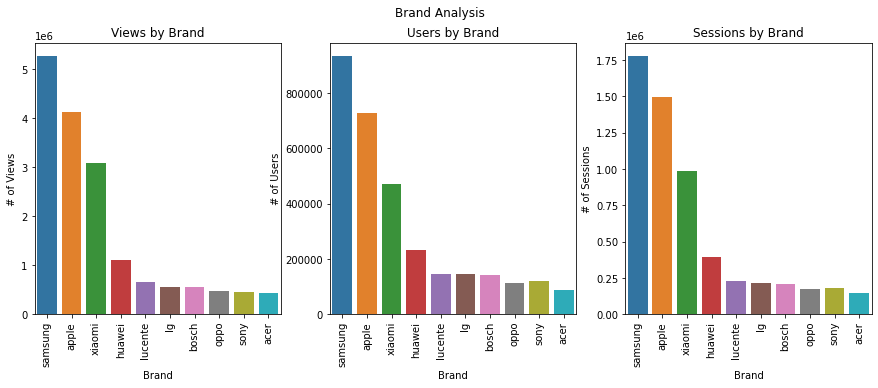

In [13]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='brand',y='N_views',data=brand_data_sorted.head(10))
plt.title('Views by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Views')

ax1 = fig.add_subplot(1,3,2)
sns.barplot(x='brand',y='N_users',data=brand_data_sorted.head(10))
plt.title('Users by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Users')

ax1 = fig.add_subplot(1,3,3)
sns.barplot(x='brand',y='N_sessions',data=brand_data_sorted.head(10))
plt.title('Sessions by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Sessions')

fig.suptitle('Brand Analysis - Top')

Text(0.5, 0.98, 'Brand Analysis - Bottom')

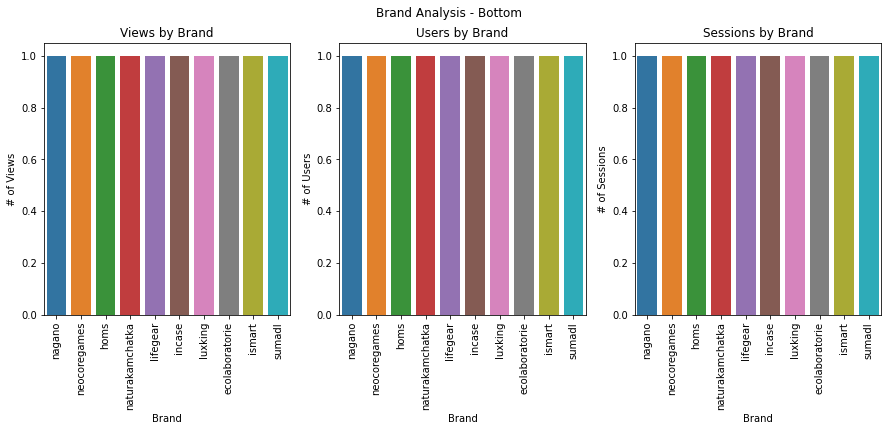

In [41]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='brand',y='N_views',data=brand_data_sorted.tail(10))
plt.title('Views by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Views')

ax1 = fig.add_subplot(1,3,2)
sns.barplot(x='brand',y='N_users',data=brand_data_sorted.tail(10))
plt.title('Users by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Users')

ax1 = fig.add_subplot(1,3,3)
sns.barplot(x='brand',y='N_sessions',data=brand_data_sorted.tail(10))
plt.title('Sessions by Brand')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('# of Sessions')

fig.suptitle('Brand Analysis - Bottom')

In [42]:
# delete to add memory
del brand_data
del brand_data_sorted

## Most popular category in October

We don't have to filter when <code>event_type</code> is purchase, because number of views is linear with number of purchase.

In [15]:
# function for splitting the category by dot ('.')
def find_category(input_cat, level=0):
    output_cat = input_cat.split('.')[level]
    return output_cat

First, we have to split the <code>category_code</code> into <code>category</code> and <code>subcategory</code> because in our data we have two levels of category.

In [16]:
oct_data['category'] = oct_data['category_code'].apply(find_category,level = 0)
oct_data['subcategory'] = oct_data['category_code'].apply(find_category,level = 1)

### Category

We can see that electronics are dominating in the category.

In [17]:
category_data = oct_data.groupby(by=['category']).agg(N_views=('category','count'),
                                                      N_users=('user_id',lambda x: x.nunique()),
                                                      N_sessions=('user_session',pd.Series.nunique)).reset_index()
category_data_sorted = category_data.sort_values(by='N_views',ascending=False)

Text(0.5, 0.98, 'Category Analysis')

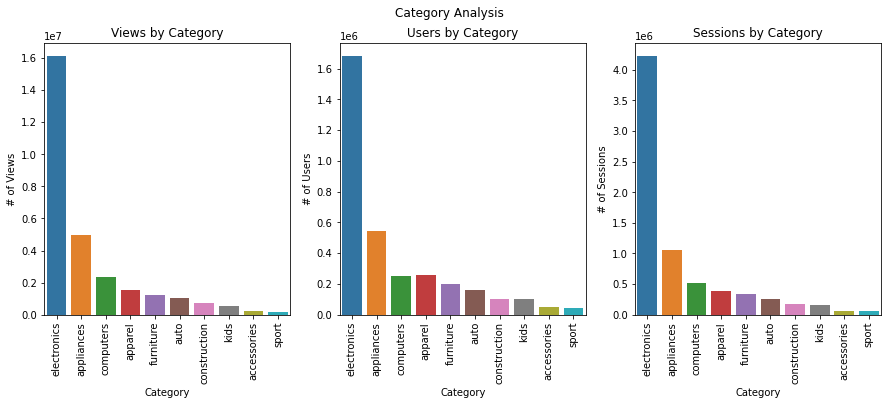

In [18]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='category',y='N_views',data=category_data_sorted.head(10))
plt.title('Views by Category')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('# of Views')

ax1 = fig.add_subplot(1,3,2)
sns.barplot(x='category',y='N_users',data=category_data_sorted.head(10))
plt.title('Users by Category')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('# of Users')

ax1 = fig.add_subplot(1,3,3)
sns.barplot(x='category',y='N_sessions',data=category_data_sorted.head(10))
plt.title('Sessions by Category')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('# of Sessions')

fig.suptitle('Category Analysis')

### Sub-category

Again, smartphone is dominating. But, our clothing sub-category needs improvement.

In [19]:
subcategory_data = oct_data.groupby(by=['category','subcategory']).agg(N_views=('category','count'),
                                                                       N_users=('user_id',lambda x: x.nunique()),
                                                                       N_sessions=('user_session',pd.Series.nunique)).reset_index()
subcategory_data_sorted = subcategory_data.sort_values(by='N_views',ascending=False)

Text(0.5, 0.98, 'Subcategory Analysis - Top')

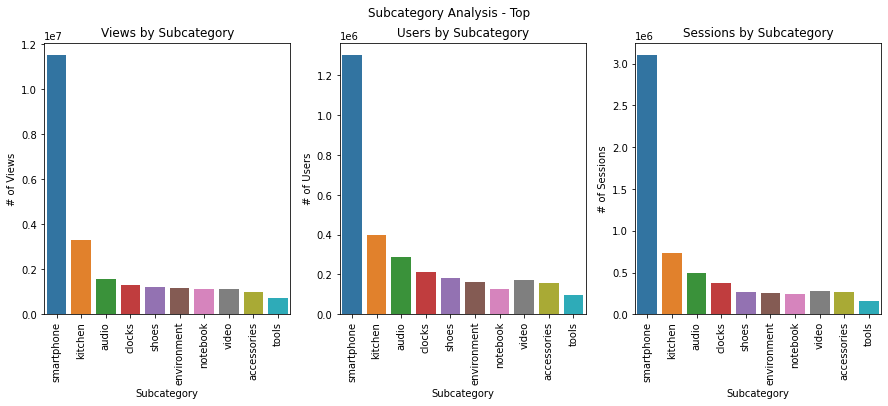

In [20]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='subcategory',y='N_views',data=subcategory_data_sorted.head(10))
plt.title('Views by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Views')

ax1 = fig.add_subplot(1,3,2)
sns.barplot(x='subcategory',y='N_users',data=subcategory_data_sorted.head(10))
plt.title('Users by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Users')

ax1 = fig.add_subplot(1,3,3)
sns.barplot(x='subcategory',y='N_sessions',data=subcategory_data_sorted.head(10))
plt.title('Sessions by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Sessions')

fig.suptitle('Subcategory Analysis - Top')

Text(0.5, 0.98, 'Subcategory Analysis - Bottom')

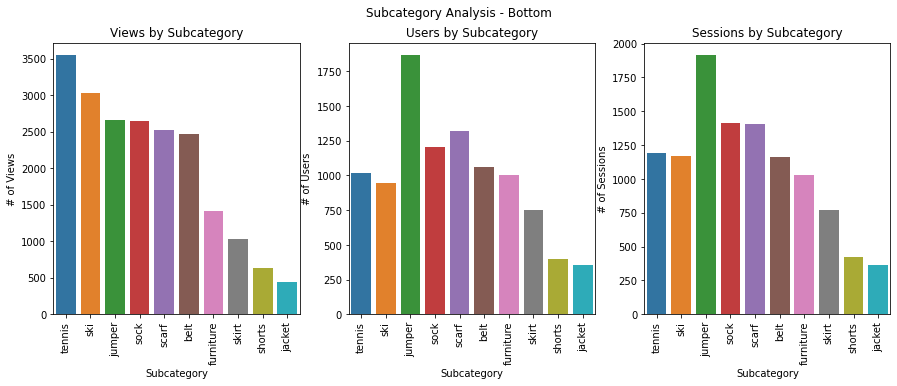

In [21]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
sns.barplot(x='subcategory',y='N_views',data=subcategory_data_sorted.tail(10))
plt.title('Views by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Views')

ax1 = fig.add_subplot(1,3,2)
sns.barplot(x='subcategory',y='N_users',data=subcategory_data_sorted.tail(10))
plt.title('Users by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Users')

ax1 = fig.add_subplot(1,3,3)
sns.barplot(x='subcategory',y='N_sessions',data=subcategory_data_sorted.tail(10))
plt.title('Sessions by Subcategory')
plt.xlabel('Subcategory')
plt.xticks(rotation=90)
plt.ylabel('# of Sessions')

fig.suptitle('Subcategory Analysis - Bottom')

In [22]:
# delete to add memory
del category_data
del category_data_sorted
del subcategory_data
del subcategory_data_sorted

## How many visitors each date in October

Middle of October is the most popular time to visit the e-commerce. Again, daily visit is linear to daily purchase.

In [23]:
daily_data = oct_data.groupby(by=[oct_data['event_time'].dt.normalize()]).agg(N_visits=('user_session',lambda x: x.nunique()),
                                                                              N_visitors=('user_id',lambda x: x.nunique()))

Text(0.5, 0.98, 'Daily Analysis')

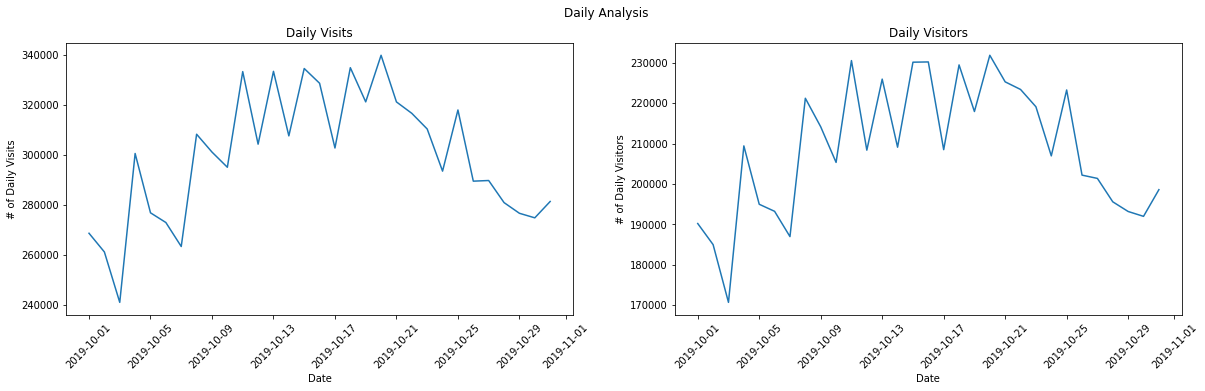

In [24]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
sns.lineplot(x='event_time',
             y='N_visits',
             data=daily_data,
             ax=ax1)
plt.title('Daily Visits')
plt.ylabel('# of Daily Visits')
plt.xlabel('Date')
plt.xticks(rotation=45)

ax1 = fig.add_subplot(1,2,2)
sns.lineplot(x='event_time',
             y='N_visitors',
             data=daily_data,
             ax=ax1)
plt.title('Daily Visitors')
plt.ylabel('# of Daily Visitors')
plt.xlabel('Date')
plt.xticks(rotation=45)

fig.suptitle('Daily Analysis')

In [25]:
purchase_filter = oct_data['event_type'] == 'purchase'
daily_purchase_data = oct_data.loc[purchase_filter].groupby(by=[oct_data['event_time'].dt.normalize()]).agg(N_purchase=('event_type','count'),
                                                                                                           Tot_purchase=('price','sum')
                                                                                                          ).reset_index()

Text(0.5, 0.98, 'Daily Purchase Analysis')

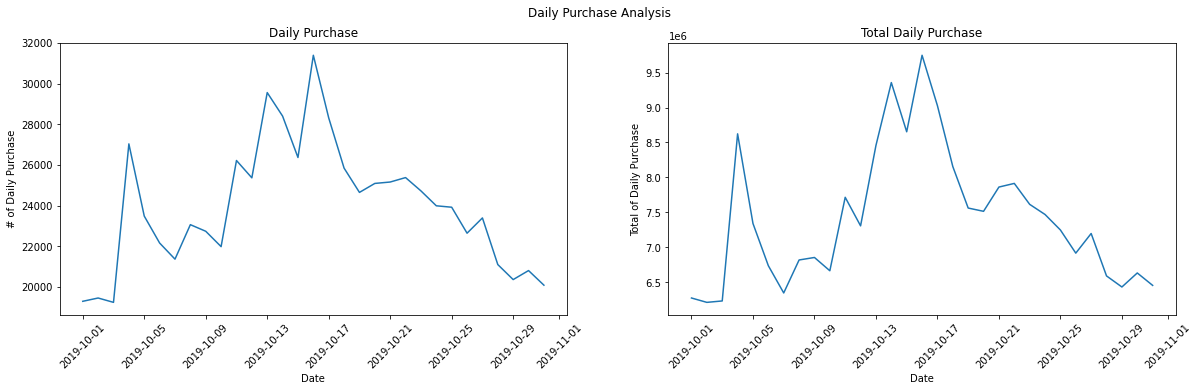

In [26]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
sns.lineplot(x='event_time',
             y='N_purchase',
             data=daily_purchase_data,
             ax=ax1)
plt.title('Daily Purchase')
plt.ylabel('# of Daily Purchase')
plt.xlabel('Date')
plt.xticks(rotation=45)

ax1 = fig.add_subplot(1,2,2)
sns.lineplot(x='event_time',
             y='Tot_purchase',
             data=daily_purchase_data,
             ax=ax1)
plt.title('Total Daily Purchase')
plt.ylabel('Total of Daily Purchase')
plt.xlabel('Date')
plt.xticks(rotation=45)

fig.suptitle('Daily Purchase Analysis')

## Most popular day in October

Friday is the most popular day in October, followed by Sunday, if we are looking by the mean only.

([<matplotlib.axis.XTick at 0x7f3406ae98d0>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

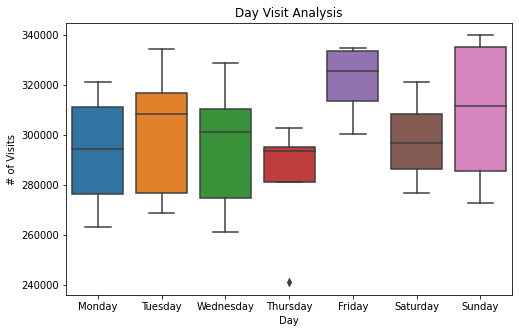

In [33]:
pop_day_range = pd.date_range('2019-10-01', '2019-10-31', freq='D').to_series()

plt.figure(figsize=(8,5))
sns.boxplot(x=pop_day_range.dt.dayofweek,
            y='N_visits',
            data=daily_data)
plt.title('Day Visit Analysis')
plt.ylabel('# of Visits')
plt.xlabel('Day')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

## How good is our sales over time?

One indicator to know how is our e-commerce's performance is by defining a new metrics, which is a ratio between how many purchases were made in one visits.

Same results, highest metrics occurs on mid-October.

In [37]:
daily_data=pd.merge(left=daily_data,
                    right=daily_purchase_data,
                    left_on=['event_time'],
                    right_on=['event_time'],
                    how='left')

daily_data['metrics'] = daily_data['N_purchase']/daily_data['N_visits']

(array([18170., 18174., 18178., 18182., 18186., 18190., 18194., 18198.,
        18201.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

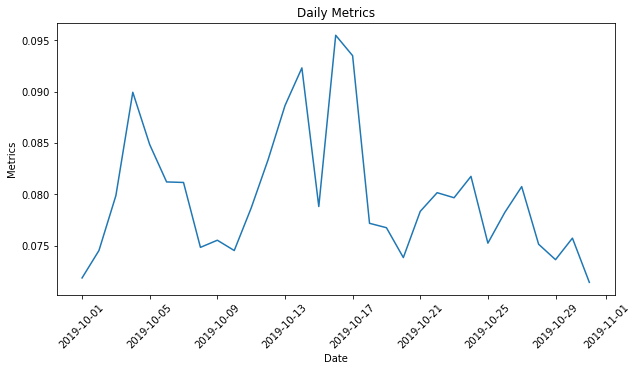

In [38]:
plt.figure(figsize=(10,5))
sns.lineplot(x='event_time',
             y='metrics',
             data=daily_data)
plt.title('Daily Metrics')
plt.ylabel('Metrics')
plt.xlabel('Date')
plt.xticks(rotation=45)

In [39]:
del daily_data
del daily_purchase_data

# Predicting if customer will purchase the item or not

In order to put our data into machine learning model, I have to define some new features:
* category
* subcategory
* N_day
* N_activity
* is_purchased

## Preparing the new feature

In [70]:
# take some column only where event_type = cart or purchase
oct_targets = oct_data.loc[oct_data["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
# is_purchased
oct_targets["is_purchased"] = np.where(oct_targets["event_type"]=="purchase",1,0)
# grouping
oct_targets["is_purchased"] = oct_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
# drop duplicates
oct_targets = oct_targets.loc[oct_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
# N_day
oct_targets['N_day'] = oct_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
# dropping the na values
oct_targets.dropna(how='any', inplace=True)
# category
oct_targets["category"] = oct_targets["category"].str.split(".",expand=True)[0].astype('category')
# subcategory
oct_targets["subcategory"] = oct_targets["category_code"].str.split(".",expand=True)[1].astype('category')

In [71]:
# take the non userid non view
cart_purchase = oct_data.loc[oct_data["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase.dropna(how='any', inplace=True)
cart_purchase_activity = oct_data.loc[oct_data['user_id'].isin(cart_purchase['user_id'])]

In [72]:
# N_activity
activity_in_session = cart_purchase_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "N_activity"})

In [74]:
# merge with N_activity
oct_targets = oct_targets.merge(activity_in_session, on='user_session', how='left')
oct_targets['N_activity_x'] = oct_targets['N_activity_x'].fillna(0)
# look at our machine learning feature
oct_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,subcategory,is_purchased,N_day,N_activity_x,N_activity_y
0,2019-10-01 00:09:33,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,1,1,4.0,4.0
1,2019-10-01 00:11:00,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,audio,0,1,4.0,4.0
2,2019-10-01 02:17:59,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,smartphone,0,1,7.0,7.0
3,2019-10-01 02:19:36,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,electronics,smartphone,1,1,16.0,16.0
4,2019-10-01 02:19:43,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,electronics,smartphone,1,1,10.0,10.0


## Resampling

In [81]:
is_purchase = oct_targets[oct_targets['is_purchased'] == 1]
not_purchase = oct_targets[oct_targets['is_purchased'] == 0]

is_purchase_new = resample(is_purchase,
                           replace = False,
                           n_samples = 270000,
                           random_state = 29)
not_purchase_new = resample(not_purchase,
                            replace = False,
                            n_samples = 270000,
                            random_state = 29)

resampled = pd.concat([is_purchase_new, not_purchase_new])

In [88]:
features = resampled.reindex(columns=['brand', 'price', 'N_day', 'category', 'subcategory', 'N_activity_x'])

## Encode the categorical variable

In [95]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(resampled.loc[:,'brand'].copy())
features.loc[:,'N_day'] = LabelEncoder().fit_transform(resampled.loc[:,'N_day'].copy())
features.loc[:,'category'] = LabelEncoder().fit_transform(resampled.loc[:,'category'].copy())
features.loc[:,'subcategory'] = LabelEncoder().fit_transform(resampled.loc[:,'subcategory'].copy())

# check our data
features_target = LabelEncoder().fit_transform(resampled['is_purchased'])
features.head()

,brand,price,N_day,category,subcategory,N_activity_x,event_weekday
176992,159,153.84,6,7,27,4.0,6
424833,292,1149.08,3,7,27,9.0,3
349169,292,170.89,6,7,27,14.0,6
347566,359,187.89,6,7,27,9.0,6
11317,21,360.34,2,7,9,11.0,2


## Do the machine learning

In [102]:
# split the data into train and test by 80:20
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    features_target, 
                                                    test_size = 0.2, 
                                                    random_state = 29)

In [ ]:
# change to numeric so our model can train it
features['brand'] = pd.to_numeric(features['brand'])
features['N_day'] = pd.to_numeric(features['N_day'])
features['category'] = pd.to_numeric(features['category'])
features['subcategory'] = pd.to_numeric(features['subcategory'])
features['N_activity_x'] = pd.to_numeric(features['N_activity_x'])

In [103]:
# train our model
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[03:46:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


## Result

We can see that our accuracy is around $61.1\%$ with the most important feature is N_activity_x which is how many activity that user made in one session.

In [104]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6114537037037037


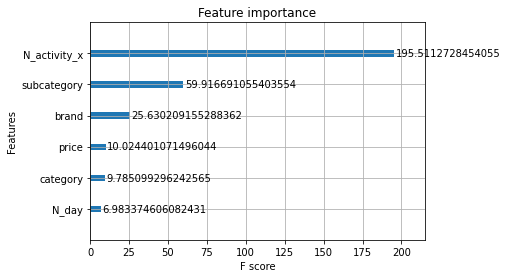

In [105]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()